### Load Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/raw/yc_startups.csv")
print(df.head())

       name                         location  \
0     RunRL           San Francisco, CA, USA   
1      mrge  London, England, United Kingdom   
2    Partcl           San Francisco, CA, USA   
3  LineWise                              NaN   
4     Linkd           San Francisco, CA, USA   

                                         description  
0  Run RL on any LLM, with any reward function. N...  
1                    AI-powered code review platform  
2                  GPU accelerated chip design tools  
3  Help manufacturers capture, scale, and apply t...  
4     Find warm connections you didn’t know you had.  


### Inspect Data

In [3]:
print(df.info())
print(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         1000 non-null   object
 1   location     777 non-null    object
 2   description  997 non-null    object
dtypes: object(3)
memory usage: 23.6+ KB
None
        name                location description
count   1000                     777         997
unique   998                      74         996
top     Remy  San Francisco, CA, USA     Stealth
freq       2                     493           2


In [4]:
df.drop_duplicates(inplace=True)
print(df.describe(include='all'))

        name                location description
count   1000                     777         997
unique   998                      74         996
top     Remy  San Francisco, CA, USA     Stealth
freq       2                     493           2


### Minimal Text Cleaning

In [5]:
import re

def clean_text(text):
    # Ensure text is a string (in case of missing values)
    if not isinstance(text, str):
        return ""
    # Remove non-alphanumeric characters (except spaces) and lowercase the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()

# Apply cleaning function on the description column (create a new column for cleaned text)
df['cleaned_description'] = df['description'].apply(clean_text)
print(df[['description', 'cleaned_description']].head())

                                         description  \
0  Run RL on any LLM, with any reward function. N...   
1                    AI-powered code review platform   
2                  GPU accelerated chip design tools   
3  Help manufacturers capture, scale, and apply t...   
4     Find warm connections you didn’t know you had.   

                                 cleaned_description  
0  run rl on any llm with any reward function now...  
1                     aipowered code review platform  
2                  gpu accelerated chip design tools  
3  help manufacturers capture scale and apply tri...  
4       find warm connections you didnt know you had  


### Basic EDA

In [6]:
sf = len(df[df['location'] == "San Francisco, CA, USA"])
nyc = len(df[df['location'] == "New York, NY, USA"])
valid = len(df) - len(df[df['location'].isna()])
print(f"San Francisco: {sf} ({sf/valid*100:.2f}%)")
print(f"New York: {nyc} ({nyc/valid*100:.2f}%)")
print(f"Other: {valid - sf - nyc} ({(valid - sf - nyc)/valid*100:.2f}%)")

San Francisco: 493 (63.45%)
New York: 93 (11.97%)
Other: 191 (24.58%)


In [7]:
from collections import Counter

# Combine all cleaned descriptions into one large text
all_text = " ".join(df['cleaned_description'])
words = all_text.split()
word_counts = Counter(words)

# Display the top 20 most common words
print(word_counts.most_common(20))


[('for', 510), ('ai', 403), ('and', 163), ('the', 150), ('to', 98), ('with', 86), ('agents', 76), ('your', 62), ('platform', 60), ('data', 55), ('in', 53), ('that', 51), ('software', 49), ('aipowered', 46), ('a', 33), ('of', 31), ('building', 30), ('an', 29), ('copilot', 28), ('source', 27)]


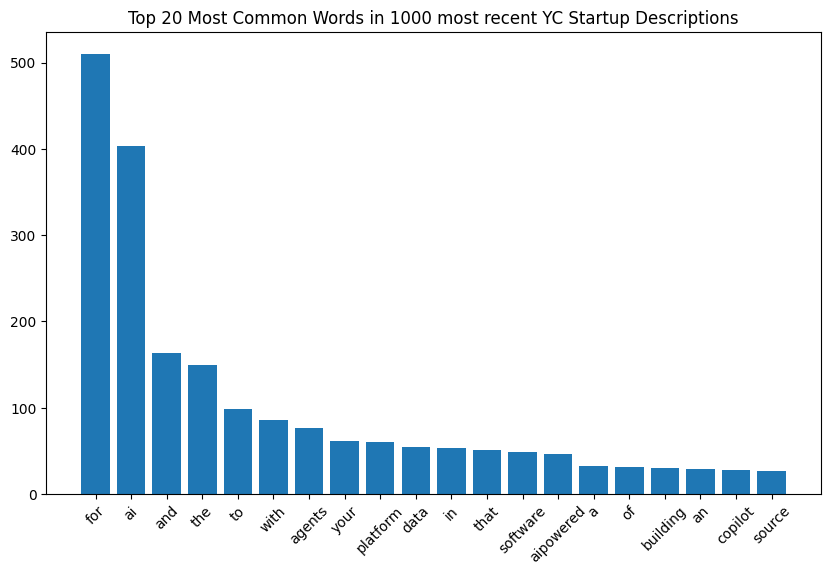

In [8]:
import matplotlib.pyplot as plt

# Get the top 20 words and their counts
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words in 1000 most recent YC Startup Descriptions")
plt.show()

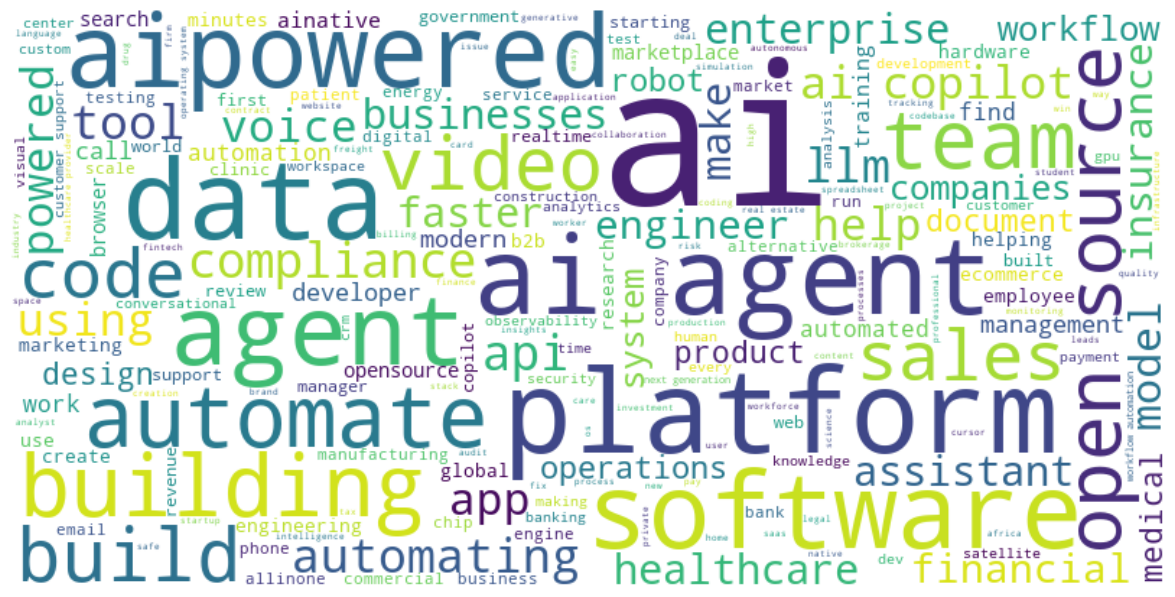

In [9]:
from wordcloud import WordCloud

# Create and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


### Topic Modeling with LDA

Extract latent topics from the descriptions using Latent Dirichlet Allocation (LDA). This helps in detecting clusters of related words that represent trends.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_description'])

In [11]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [12]:
# Number of words to display per topic
n_top_words = 10

for index, topic in enumerate(lda_model.components_):
    print(f"\nTOPIC #{index + 1}")
    # Get the indices of the top words
    top_indices = topic.argsort()[-n_top_words:]
    # Map indices to actual words
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    print(top_words)



TOPIC #1
['workflows', 'aipowered', 'hardware', 'data', 'powered', 'automate', 'faster', 'design', 'software', 'ai']

TOPIC #2
['assistant', 'healthcare', 'building', 'voice', 'teams', 'source', 'open', 'copilot', 'agents', 'ai']

TOPIC #3
['new', 'insurance', 'banking', 'testing', 'agents', 'modern', 'ainative', 'building', 'llm', 'platform']

TOPIC #4
['data', 'aipowered', 'automation', 'api', 'automating', 'companies', 'help', 'agents', 'platform', 'ai']

TOPIC #5
['robots', 'healthcare', 'training', 'insurance', 'platform', 'medical', 'build', 'aipowered', 'data', 'ai']


### Embedding-Based Clustering

##### Generate Embeddings Using Sentence-BERT

In [16]:
df.head()

,name,location,description,cleaned_description
0,RunRL,"San Francisco, CA, USA","Run RL on any LLM, with any reward function. N...",run rl on any llm with any reward function now...
1,mrge,"London, England, United Kingdom",AI-powered code review platform,aipowered code review platform
2,Partcl,"San Francisco, CA, USA",GPU accelerated chip design tools,gpu accelerated chip design tools
3,LineWise,NaN,"Help manufacturers capture, scale, and apply t...",help manufacturers capture scale and apply tri...
4,Linkd,"San Francisco, CA, USA",Find warm connections you didn’t know you had.,find warm connections you didnt know you had


In [18]:
from sentence_transformers import SentenceTransformer

# load pretrained model; this model is both lightweight and stable
model = SentenceTransformer('all-MiniLM-L6-v2')

# generate embeddings for each description
descriptions = df['cleaned_description'].tolist()
embeddings = model.encode(descriptions, show_progress_bar=True)

Batches: 100%|██████████| 32/32 [00:01<00:00, 29.80it/s]


##### Apply k-means clustering

In [22]:
from sklearn.cluster import KMeans

# set number of clusters
num_clusters = 5

# initialize and run KMeans clustering on embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# add cluster labels to dataframe
df['cluster'] = cluster_labels

/Users/andrewyuan/dev/trend-prediction-ai/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
for cluster in range(num_clusters):
    cluster_companies = df[df['cluster'] == cluster]['name'].tolist()
    print(f"Cluster {cluster}: {', '.join(cluster_companies)}")

Cluster 0: RunRL, Partcl, Linkd, StarJar, Dollyglot, HUD, Praxim, awen, Sublingual, Nuclear Software, Steinmetz, TamLabs, Inversion Semiconductor, Olive, Exla, Infinite, Closure, Red Barn Robotics, Splash Inc., Emergent, Instinct, Maritime Fusion, Peppr AI, Proception Inc, Reditus Space, Waypoint Transit, TrainLoop, Artifact, TensorPool, Lucid, Mentra, superglue, ReJot, Sift Dev, Pinch, Onlook, Mecha Health, Alice.tech, Axal, SubImage, Confident AI, Forge Automation, Orbital Operations, Browser Use, jo, Asteroid, CopyCat, ZeroEntropy, Subtrace, Variant, Consus, Fabricate, Foundry, Gander, Kura AI, Platus, SRE.ai, Friday, Encore, Upshift, vly.ai, Ryvn, Ultralight, HYBRD, Andoria, Forerunner AI, Raycaster, Crustdata, Moonshine, Circlemind, BeerMe, Alex, Codebuff, Bifrost Orbital, Archil, Void, Getcho, Cobblestone, et al., expand.ai, Unsloth AI, Pinnacle, Theseus, Ficra, Snowpilot, Proxis, dmodel, DreamRP, Abel Police, Biocartesian, Rewbi, Blast, Plume, XTraffic, reworks, Ares Industries,

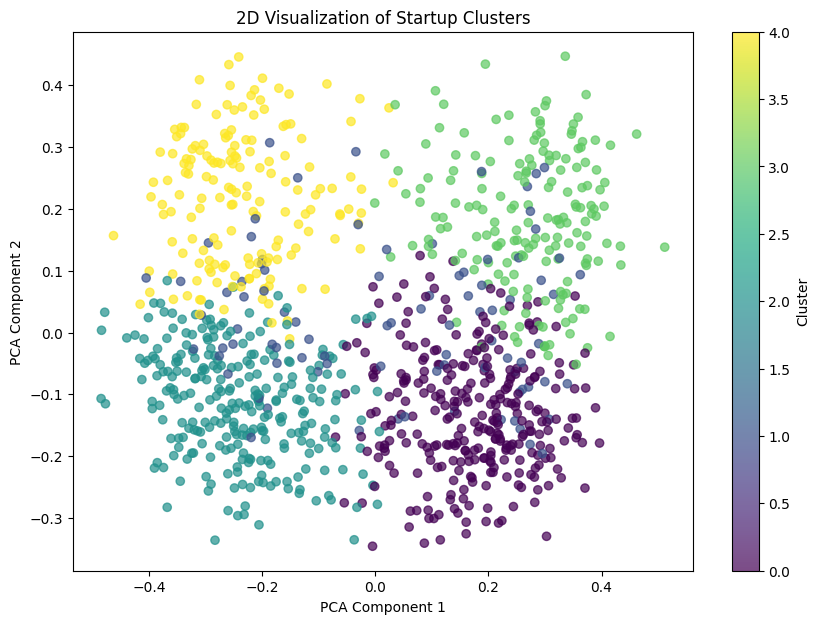

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for plotting
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                      c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("2D Visualization of Startup Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster")
plt.show()
